In [1]:
# basic library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import requests
import gzip
import urllib.request
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from collections import Counter
from tqdm import tqdm_notebook
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
%matplotlib inline
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, multiply, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj

2024-07-07 18:29:35.729489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 18:29:35.729547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 18:29:35.731115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


EXPLORE + SPLITTING DATA (dari 2a)

In [3]:
# direktori data full
dir_folder = 'dataset_nomor2-3'

In [4]:
# buat direktori jika belum ada
os.makedirs(dir_folder, exist_ok=True)

In [5]:
# file yang mau di download
files = {
    "train-images-idx3-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
}

In [6]:
# function untuk download file
def download_file(url, dest):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"File downloaded: {dest}")
    else:
        print(f"Failed to download file from {url}")

In [7]:
# download semua file
for filename, url in files.items():
    dest_path = os.path.join(dir_folder, filename)
    download_file(url, dest_path)

File downloaded: dataset_nomor2-3/train-images-idx3-ubyte.gz
File downloaded: dataset_nomor2-3/train-labels-idx1-ubyte.gz
File downloaded: dataset_nomor2-3/t10k-images-idx3-ubyte.gz
File downloaded: dataset_nomor2-3/t10k-labels-idx1-ubyte.gz


In [8]:
# function untuk load data
def load_data():
    x_train_path = os.path.join(dir_folder, 'train-images-idx3-ubyte.gz')
    y_train_path = os.path.join(dir_folder, 'train-labels-idx1-ubyte.gz')
    x_test_path = os.path.join(dir_folder, 't10k-images-idx3-ubyte.gz')
    y_test_path = os.path.join(dir_folder, 't10k-labels-idx1-ubyte.gz')
    
    with gzip.open(x_train_path, 'rb') as f:
        x_train = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
    
    with gzip.open(y_train_path, 'rb') as f:
        y_train = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
    with gzip.open(x_test_path, 'rb') as f:
        x_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
    
    with gzip.open(y_test_path, 'rb') as f:
        y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
    return (x_train, y_train), (x_test, y_test)

In [9]:
# function untuk scaling data
def scale_data(x_train, x_test):
    x_train_scaled = x_train.astype('float32') / 255.
    x_test_scaled = x_test.astype('float32') / 255.
    return x_train_scaled, x_test_scaled

LOAD DATA

In [10]:
(x_train, y_train), (x_test, y_test) = load_data()

SCALING DATA

In [11]:
x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

FILTER HANYA AMBIL LABEL PULLOVER (2) DAN DRESS (3)

In [12]:
pullover_dress_filter = (y_train == 2) | (y_train == 3)
x_train_filtered = x_train_scaled[pullover_dress_filter]
y_train_filtered = y_train[pullover_dress_filter]

pullover_dress_filter_test = (y_test == 2) | (y_test == 3)
x_test_filtered = x_test_scaled[pullover_dress_filter_test]
y_test_filtered = y_test[pullover_dress_filter_test]

SPLITTING 80% TRAINING, 10% VALIDATION, 10% TEST

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_filtered, y_train_filtered, test_size=0.2, random_state=42)

# gunakan data test yang telah difilter
x_test = x_test_filtered
y_test = y_test_filtered

In [14]:
num_train_samples = x_train.shape[0]
num_val_samples = x_val.shape[0]
num_test_samples = x_test.shape[0]
num_classes = len(np.unique(y_train))

print(f"Jumlah data training: {num_train_samples}")
print(f"Jumlah data validation: {num_val_samples}")
print(f"Jumlah data testing: {num_test_samples}")
print(f"Jumlah kelas: {num_classes}")

Jumlah data training: 9600
Jumlah data validation: 2400
Jumlah data testing: 2000
Jumlah kelas: 2


MENDEFINISIKAN KELAS (untuk kemudahan saya saja)

In [15]:
class_names = {
    2: "Pullover",
    3: "Dress"
}

In [16]:
def show_and_validate_labels(labels, class_names):
    unique_labels = np.unique(labels)
    print("Label yang ada dalam dataset:")
    for label in unique_labels:
        if label in class_names:
            print(f"Label {label}: {class_names[label]}")
        else:
            print(f"Label {label} tidak ada dalam deskripsi kelas!")

In [17]:
show_and_validate_labels(y_train, class_names)

Label yang ada dalam dataset:
Label 2: Pullover
Label 3: Dress


SHOW IMAGE

In [18]:
def show_images_per_class(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        index = np.where(labels == label)[0][0]
        plt.subplot(1, 2, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f'{class_names[label]} ({label})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

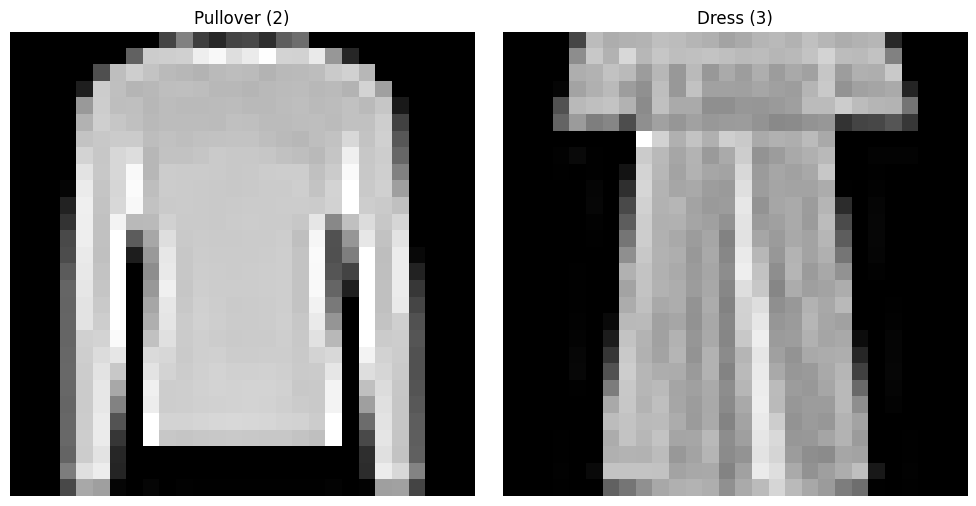

In [19]:
show_images_per_class(x_train, y_train, class_names)

MELIHAT DIMENSI DAN BENTUK DATA

In [20]:
print(f"Bentuk data training: {x_train.shape}")
print(f"Bentuk data validation: {x_val.shape}")
print(f"Bentuk data testing: {x_test.shape}")

Bentuk data training: (9600, 28, 28)
Bentuk data validation: (2400, 28, 28)
Bentuk data testing: (2000, 28, 28)


MELIHAT DISTRIBUSI DATA

In [21]:
def show_data_distribution(labels, title):
    label_counts = Counter(labels)
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah')
    plt.title(title)
    plt.xticks(list(class_names.keys()), list(class_names.values()), rotation=45)
    plt.show()

Distribusi data training:


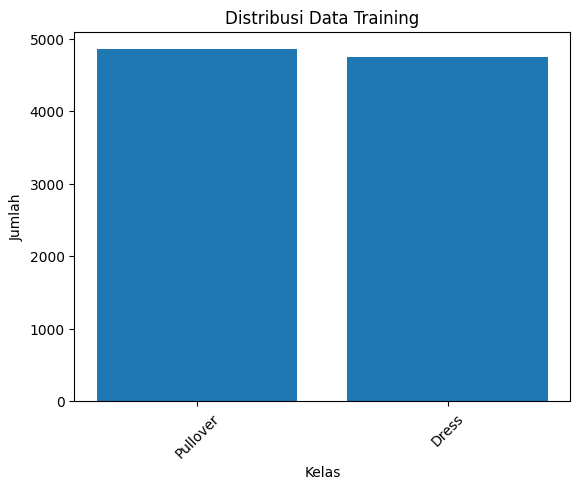

In [22]:
print("Distribusi data training:")
show_data_distribution(y_train, "Distribusi Data Training")

Distribusi data validation:


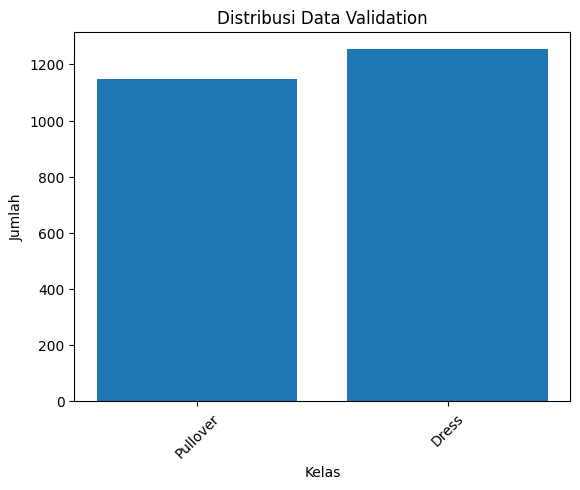

In [23]:
print("Distribusi data validation:")
show_data_distribution(y_val, "Distribusi Data Validation")

Distribusi data testing:


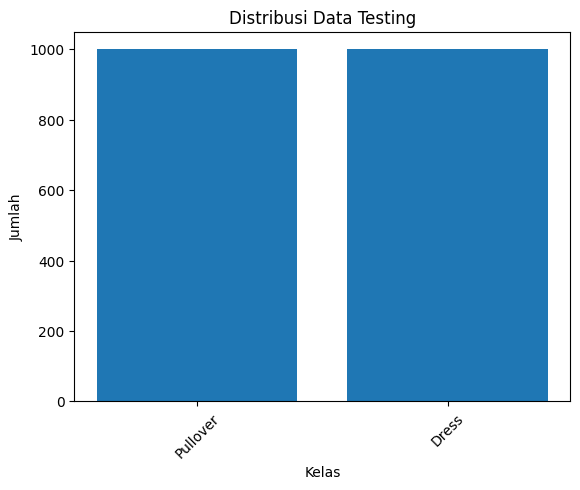

In [24]:
print("Distribusi data testing:")
show_data_distribution(y_test, "Distribusi Data Testing")

In [25]:
# distribusi data training
train_distribution = Counter(y_train)
print("Distribusi data training:")
print(train_distribution)

# distribusi data validation
val_distribution = Counter(y_val)
print("\nDistribusi data validation:")
print(val_distribution)

# distribusi data testing
test_distribution = Counter(y_test)
print("\nDistribusi data testing:")
print(test_distribution)

Distribusi data training:
Counter({2: 4853, 3: 4747})

Distribusi data validation:
Counter({3: 1253, 2: 1147})

Distribusi data testing:
Counter({2: 1000, 3: 1000})


MODEL GAN

In [26]:
# pip install pytorch-fid

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import os
import requests
import gzip
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
from pytorch_fid import fid_score

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [29]:
# Load datasets (assuming x_train, y_train, x_val, y_val are already loaded)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_size ** 2),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, img_size, img_size)
        return img

Generator:
Embedding layer untuk label.
Menggabungkan noise input dan embedding label.
Linear layer dengan unit berturut-turut dari (noise + n_labels) ke 128, 128 ke 256, 256 ke 512, dan 512 ke (img_size ** 2).

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(num_classes + img_size ** 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity


Discriminator:
Embedding layer untuk label.
Menggabungkan input gambar yang diluruskan (flattened) dan embedding label.
Linear layer dengan unit berturut-turut dari (n_labels + img_size ** 2) ke 512, 512 ke 1024, 1024 ke 1024, dan 1024 ke 1.

In [32]:
# Hyperparameters
img_size = 28
num_classes = 10
noise_dim = 100

# inisiasi models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [33]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))


TRAIN

In [34]:
n_epochs = 100
sample_interval = 200
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        valid = torch.ones((batch_size, 1), dtype=torch.float, device=device, requires_grad=False)
        fake = torch.zeros((batch_size, 1), dtype=torch.float, device=device, requires_grad=False)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer_G.zero_grad()

        z = torch.randn((batch_size, noise_dim), device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)

        gen_imgs = generator(z, gen_labels)

        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)
   
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()

        real_preds = validity_real > 0.5
        fake_preds = validity_fake < 0.5
        d_accuracy = torch.mean(torch.cat((real_preds, fake_preds), 0).float())

        g_accuracy = torch.mean((validity > 0.5).float())
        
        # Print progress
        if i % sample_interval == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.6f}, acc: {d_accuracy.item():.6f}] [G loss: {g_loss.item():.6f}, acc: {g_accuracy.item():.6f}]")


[Epoch 0/100] [Batch 0/150] [D loss: 0.689962, acc: 0.500000] [G loss: 0.679318, acc: 1.000000]
[Epoch 1/100] [Batch 0/150] [D loss: 0.224240, acc: 0.906250] [G loss: 2.835920, acc: 0.140625]
[Epoch 2/100] [Batch 0/150] [D loss: 0.103139, acc: 0.968750] [G loss: 3.819006, acc: 0.000000]
[Epoch 3/100] [Batch 0/150] [D loss: 0.079996, acc: 0.976562] [G loss: 4.315065, acc: 0.046875]
[Epoch 4/100] [Batch 0/150] [D loss: 0.118227, acc: 0.960938] [G loss: 5.133365, acc: 0.000000]
[Epoch 5/100] [Batch 0/150] [D loss: 0.147437, acc: 0.937500] [G loss: 5.967844, acc: 0.000000]
[Epoch 6/100] [Batch 0/150] [D loss: 0.098064, acc: 0.976562] [G loss: 6.907206, acc: 0.000000]
[Epoch 7/100] [Batch 0/150] [D loss: 0.065506, acc: 0.984375] [G loss: 5.224008, acc: 0.000000]
[Epoch 8/100] [Batch 0/150] [D loss: 0.161413, acc: 0.937500] [G loss: 5.654472, acc: 0.062500]
[Epoch 9/100] [Batch 0/150] [D loss: 0.149841, acc: 0.953125] [G loss: 5.333866, acc: 0.046875]
[Epoch 10/100] [Batch 0/150] [D loss: 0.

In [35]:
# Save generated images for FID evaluation
def save_images(generator, num_images, noise_dim, label_dim, img_size, path):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, noise_dim, device=device)
        labels = torch.randint(0, label_dim, (num_images,), device=device)
        gen_imgs = generator(noise, labels)
        gen_imgs = (gen_imgs + 1) / 2.0  # Rescale images to [0, 1]
        for i in range(num_images):
            img = transforms.ToPILImage()(gen_imgs[i].cpu())
            img.save(os.path.join(path, f"img_{i}.png"))
    generator.train()

In [36]:
# Generate and save images
generated_images_path = "generated_images"
os.makedirs(generated_images_path, exist_ok=True)
save_images(generator, 2000, noise_dim, num_classes, img_size, generated_images_path)

In [39]:
real_images_path = 'dataset_nomor2-3'

In [41]:
import os
import numpy as np
from PIL import Image

In [42]:
# Ensure the directory exists
os.makedirs(real_images_path, exist_ok=True)

# Function to save real images with specific labels
def save_filtered_real_images(images, labels, path, class_names):
    # Filter the images based on the specified labels (Pullover and Dress)
    filter_mask = np.isin(labels, list(class_names.keys()))
    filtered_images = images[filter_mask]
    filtered_labels = labels[filter_mask]

    # Save the filtered images to the specified directory
    for i in range(filtered_images.shape[0]):
        img = Image.fromarray((filtered_images[i] * 255).astype(np.uint8))  # Convert back to [0, 255] range
        img.save(os.path.join(path, f"real_img_{i}_label_{filtered_labels[i]}.png"))

# Save the filtered real images from the test dataset
save_filtered_real_images(x_test, y_test, real_images_path, class_names)

In [43]:
import torchvision.transforms as transforms

# Define a function to save real images from the test dataset
def save_real_images(real_images, path):
    os.makedirs(path, exist_ok=True)
    for i in range(real_images.size(0)):
        img = transforms.ToPILImage()(real_images[i].cpu())
        img.save(os.path.join(path, f"real_img_{i}.png"))

# Generate and save images for FID evaluation
fid_evaluation_path_gen = "/kaggle/working/generated_images"
fid_evaluation_path_real = "/kaggle/working/dataset_nomor2-3"
num_fid_images = 1000  # Number of images to generate for FID evaluation

# Ensure the directories exist
os.makedirs(fid_evaluation_path_gen, exist_ok=True)
os.makedirs(fid_evaluation_path_real, exist_ok=True)

# Generate and save synthetic images
save_images(generator, num_fid_images, noise_dim, num_classes, img_size, fid_evaluation_path_gen)

# Save real images from the test dataset
save_real_images(x_test_tensor[:num_fid_images], fid_evaluation_path_real)

# Compute FID score
paths = [fid_evaluation_path_real, fid_evaluation_path_gen]
fid_value = fid_score.calculate_fid_given_paths(paths, batch_size=50, device=device, dims=2048)
print(f"FID score between real and generated images: {fid_value}")

  0%|          | 0/60 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 60/60 [00:06<00:00,  9.38it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


FID score between real and generated images: 388.92528963833894


Berarti gambar baju dan gaun yang dihasilkan oleh model masih juah berbeda dari gambar asli. Di kesempatan lain waktu kemungkinan akan memperbaiki model, menyesuaikan parameter, dan melatih elbih lama agar bisa menghasilkan gambar yang lebih realistis